##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# SavedModel 形式の使用

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/guide/saved_model"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/guide/saved_model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a> </td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/guide/saved_model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/guide/saved_model.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

SavedModel には、トレーニング済みのパラメータ（`tf.Variable`）や計算を含む完全な TensorFlow プログラムが含まれます。実行するために元のモデルのビルディングコードを必要としないため、[TFLite](https://tensorflow.org/lite)、[TensorFlow.js](https://js.tensorflow.org/)、[TensorFlow Serving](https://www.tensorflow.org/tfx/serving/tutorials/Serving_REST_simple)、または [TensorFlow Hub](https://tensorflow.org/hub) との共有やデプロイに便利です。

以下の API を使用して、SavedModel 形式でのモデルの保存と読み込みを行えます。

- 低レベルの `tf.saved_model` API。このドキュメントでは、この API の使用方法を詳しく説明しています。
    - 保存: `tf.saved_model.save(model, path_to_dir)`
    - 読み込み: `model = tf.saved_model.load(path_to_dir)`
- 高レベルの `tf.keras.Model` API。[Keras の保存とシリアル化ガイド](https://www.tensorflow.org/guide/keras/save_and_serialize)をご覧ください。
- トレーニング中の重みの保存/読み込みのみを実行する場合は、[チェックポイントガイド](./checkpoint.ipynb)をご覧ください。

注意: TensorFlow モデルはコードであるため、信頼できないコードには注意する必要があります。詳細は、[TensorFlow を安全に使用する](https://github.com/tensorflow/tensorflow/blob/master/SECURITY.md)をご覧ください。


## Keras を使った SavedModel の作成

廃止: Keras オブジェクトについては、新しい高レベルの `.keras` 形式と `tf.keras.Model.export` を使用することをお勧めします。これについては、[こちら](https://www.tensorflow.org/guide/keras/save_and_serialize)のガイドで説明されています。既存のコードについては、低レベルの SavedModel 形式が引き続きサポートされます。

簡単な導入として、このセクションでは、事前にトレーニング済みの Keras モデルをエクスポートし、それを使って画像分類リクエストを送信します。SavedModels のほかの作成方法については、このガイドの残りの部分で説明します。

In [2]:
import os
import tempfile

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

tmpdir = tempfile.mkdtemp()

2024-01-11 18:43:07.320116: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 18:43:07.320163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 18:43:07.321721: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
  tf.config.experimental.set_memory_growth(device, True)

 8192/61306 [===>..........................] - ETA: 0s

61306/61306 [==============================] - 0s 0us/step


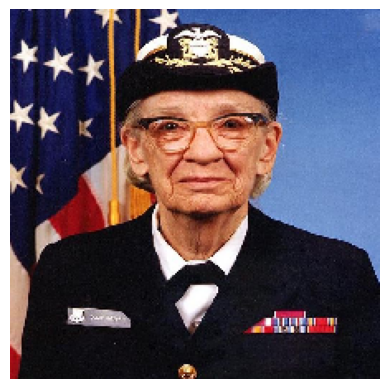

In [4]:
file = tf.keras.utils.get_file(
    "grace_hopper.jpg",
    "https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg")
img = tf.keras.utils.load_img(file, target_size=[224, 224])
plt.imshow(img)
plt.axis('off')
x = tf.keras.utils.img_to_array(img)
x = tf.keras.applications.mobilenet.preprocess_input(
    x[tf.newaxis,...])

実行例として、グレース・ホッパーの画像と Keras の次元トレーニング済み画像分類モデルを使用します（使いやすいため）。カスタムモデルも使用できますが、これについては後半で説明します。

In [5]:
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

 8192/10484 [======================>.......] - ETA: 0s

10484/10484 [==============================] - 0s 0us/step


In [6]:
pretrained_model = tf.keras.applications.MobileNet()
result_before_save = pretrained_model(x)

decoded = imagenet_labels[np.argsort(result_before_save)[0,::-1][:5]+1]

print("Result before saving:\n", decoded)

    8192/17225924 [..............................] - ETA: 0s

 4202496/17225924 [======>.......................] - ETA: 0s

17225924/17225924 [==============================] - 0s 0us/step


Result before saving:
 ['military uniform' 'bow tie' 'suit' 'bearskin' 'pickelhaube']


この画像の予測トップは「軍服」です。

In [7]:
mobilenet_save_path = os.path.join(tmpdir, "mobilenet/1/")
tf.saved_model.save(pretrained_model, mobilenet_save_path)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpwpnio7cy/mobilenet/1/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpwpnio7cy/mobilenet/1/assets


save-path は、TensorFlow Serving が使用する規則に従っており、最後のパスコンポーネント（この場合 `1/`）はモデルのバージョンを指します。Tensorflow Serving のようなツールで、相対的な鮮度を区別させることができます。

`tf.saved_model.load` で SavedModel を Python に読み込み直し、ホッパー将官の画像がどのように分類されるかを確認できます。

In [8]:
loaded = tf.saved_model.load(mobilenet_save_path)
print(list(loaded.signatures.keys()))  # ["serving_default"]

['serving_default']


インポートされるシグネチャは、必ずディクショナリを返します。シグネチャ名と出力ディクショナリキーをカスタマイズするには、「[エクスポート中のシグネチャの指定](#specifying_signatures_during_export)」を参照してください。

In [9]:
infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)

{'predictions': TensorSpec(shape=(None, 1000), dtype=tf.float32, name='predictions')}


SavedModel から推論を実行すると、元のモデルと同じ結果が得られます。

In [10]:
labeling = infer(tf.constant(x))[pretrained_model.output_names[0]]

decoded = imagenet_labels[np.argsort(labeling)[0,::-1][:5]+1]

print("Result after saving and loading:\n", decoded)

Result after saving and loading:
 ['military uniform' 'bow tie' 'suit' 'bearskin' 'pickelhaube']


## TensorFlow Serving での SavedModel の実行

SavedModels は Python から使用可能（詳細は以下参照）ですが、本番環境では通常、Python コードを使用せずに、推論専用のサービスが使用されます。これは、TensorFlow Serving を使用して SavedModel から簡単にセットアップできます。

エンドツーエンドのtensorflow-servingの例については、 [TensorFlow Serving RESTチュートリアル](https://www.tensorflow.org/tfx/tutorials/serving/rest_simple)をご覧ください。

## ディスク上の SavedModel 形式

SavedModel は、変数の値や語彙など、シリアル化されたシグネチャとそれらを実行するために必要な状態を含むディレクトリです。


In [11]:
!ls {mobilenet_save_path}

assets	fingerprint.pb	saved_model.pb	variables


`saved_model.pb` ファイルは、実際の TensorFlow プログラムまたはモデル、およびテンソル入力を受け入れてテンソル出力を生成する関数を識別する一連の名前付きシグネチャを保存します。

SavedModel には、複数のモデルバリアント（`saved_model_cli` への `--tag_set` フラグで識別される複数の `v1.MetaGraphDefs`）が含まれることがありますが、それは稀なことです。複数のモデルバリアントを作成する API には、[`tf.Estimator.experimental_export_all_saved_models`](https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator#experimental_export_all_saved_models) と TensorFlow 1.x の `tf.saved_model.Builder` があります。

In [12]:
!saved_model_cli show --dir {mobilenet_save_path} --tag_set serve

2024-01-11 18:43:23.804359: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 18:43:23.804415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 18:43:23.805873: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"


`variables` ディレクトリには、標準のトレーニングチェックポイントが含まれます（「[トレーニングチェックポイントガイド](./checkpoint.ipynb)」を参照してください）。

In [13]:
!ls {mobilenet_save_path}/variables

variables.data-00000-of-00001  variables.index


`assets` ディレクトリには、語彙テーブルを初期化するためのテキストファイルなど、TensorFlow グラフが使用するファイルが含まれます。この例では使用されません。

SavedModel には、SavedModel で何をするかといった消費者向けの情報など、TensorFlow グラフで使用されないファイルに使用する `assets.extra` ディレクトリがある場合があります。TensorFlow そのものでは、このディレクトリは使用されません。

`fingerprint.pb` ファイルには SavedModel の[フィンガープリント](https://en.wikipedia.org/wiki/Fingerprint_(computing))が含まれており、SavedModel のコンテンツを一意に識別する複数の 64 ビットハッシュで構成されています。現在、フィンガープリント API は実験的ですが、`tf.saved_model.experimental.read_fingerprint` を使用して、SavedModel フィンガープリントを `tf.saved_model.experimental.Fingerprint` オブジェクトに読み取ることが可能です。

## カスタムモデルの保存

`tf.saved_model.save` は、`tf.Module` オブジェクトと、`tf.keras.Layer` や `tf.keras.Model` などのサブクラスの保存をサポートしています。

`tf.Module` の保存と復元の例を見てみましょう。


In [14]:
class CustomModule(tf.Module):

  def __init__(self):
    super(CustomModule, self).__init__()
    self.v = tf.Variable(1.)

  @tf.function
  def __call__(self, x):
    print('Tracing with', x)
    return x * self.v

  @tf.function(input_signature=[tf.TensorSpec([], tf.float32)])
  def mutate(self, new_v):
    self.v.assign(new_v)

module = CustomModule()

`tf.Module` を保存すると、すべての `tf.Variable` 属性、`tf.function` でデコレートされたメソッド、および再帰トラバースで見つかった `tf.Module` が保存されます（この再帰トラバースについては、「[チェックポイントのチュートリアル](./checkpoint.ipynb)」を参照してください）。ただし、Python の属性、関数、およびデータは失われます。つまり、`tf.function` が保存されても、Python コードは保存されません。

Python コードが保存されないのであれば、SavedModel は関数をどのようにして復元するのでしょうか。

簡単に言えば、`tf.function` は、Python コードをトレースして ConcreteFunction（`tf.Graph` のコーラブルラッパー）を生成することで機能します。`tf.function` を保存すると、実際には `tf.function` の ConcreteFunctions のキャッシュを保存しているのです。

`tf.function` と ConcreteFunctions の関係に関する詳細は、「[tf.function ガイド](function.ipynb)」をご覧ください。

In [15]:
module_no_signatures_path = os.path.join(tmpdir, 'module_no_signatures')
module(tf.constant(0.))
print('Saving model...')
tf.saved_model.save(module, module_no_signatures_path)

Tracing with Tensor("x:0", shape=(), dtype=float32)
Saving model...
Tracing with Tensor("x:0", shape=(), dtype=float32)


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpwpnio7cy/module_no_signatures/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpwpnio7cy/module_no_signatures/assets


## カスタムモデルの読み込みと使用

Python に SavedModel を読み込むと、すべての `tf.Variable` 属性、`tf.function` でデコレートされたメソッド、および `tf.Module` は、保存された元の `tf.Module` と同じオブジェクト構造で復元されます。

In [16]:
imported = tf.saved_model.load(module_no_signatures_path)
assert imported(tf.constant(3.)).numpy() == 3
imported.mutate(tf.constant(2.))
assert imported(tf.constant(3.)).numpy() == 6

Python コードは保存されないため、新しい入力シグネチャで `tf.function` で呼び出しても失敗します。

```python
imported(tf.constant([3.]))
```

<pre>ValueError: Could not find matching function to call for canonicalized inputs ((&lt;tf.Tensor 'args_0:0' shape=(1,) dtype=float32&gt;,), {}). Only existing signatures are [((TensorSpec(shape=(), dtype=tf.float32, name=u'x'),), {})].
</pre>

### 基本のファインチューニング

変数オブジェクトを使用でき、インポートされた関数を通じてバックプロパゲーションできます。単純なケースの場合、SavedModel をファインチューニング（再トレーニング）するには、これで十分です。

In [17]:
optimizer = tf.keras.optimizers.SGD(0.05)

def train_step():
  with tf.GradientTape() as tape:
    loss = (10. - imported(tf.constant(2.))) ** 2
  variables = tape.watched_variables()
  grads = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(grads, variables))
  return loss

In [18]:
for _ in range(10):
  # "v" approaches 5, "loss" approaches 0
  print("loss={:.2f} v={:.2f}".format(train_step(), imported.v.numpy()))

loss=36.00 v=3.20
loss=12.96 v=3.92
loss=4.67 v=4.35
loss=1.68 v=4.61
loss=0.60 v=4.77
loss=0.22 v=4.86
loss=0.08 v=4.92
loss=0.03 v=4.95
loss=0.01 v=4.97
loss=0.00 v=4.98


I0000 00:00:1704998607.284908  100396 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


### 一般的な微調整

Keras の SavedModel は、より高度な微調整の事例に対処できる、プレーンな `__call__` よりも[詳細な内容](https://github.com/tensorflow/community/blob/master/rfcs/20190509-keras-saved-model.md#serialization-details)を提供します。TensorFlow Hub は、微調整の目的で共有される SavedModel に、該当する場合は次の項目を提供することをお勧めします。

- モデルに、フォワードパスがトレーニングと推論で異なるドロップアウトまたはほかのテクニックが使用されている場合（バッチの正規化など）、`__call__` メソッドは、オプションのPython 重視の `training=` 引数を取ります。この引数は、デフォルトで `False` になりますが、`True` に設定することができます。
- `__call__` 属性の隣には、対応する変数リストを伴う `.variable` と `.trainable_variable` 属性があります。もともとトレーニング可能であっても、微調整中には凍結されるべき変数は、`.trainable_variables` から省略されます。
- レイヤとサブモデルの属性として重みの正規化を表現する Keras のようなフレームワークのために、`.regularization_losses` 属性も使用できます。この属性は、値が合計損失に追加することを目的とした引数無しの関数のリストを保有します。

最初の MobileNet の例に戻ると、これらの一部が動作していることを確認できます。

In [19]:
loaded = tf.saved_model.load(mobilenet_save_path)
print("MobileNet has {} trainable variables: {}, ...".format(
          len(loaded.trainable_variables),
          ", ".join([v.name for v in loaded.trainable_variables[:5]])))

MobileNet has 83 trainable variables: conv1/kernel:0, conv1_bn/gamma:0, conv1_bn/beta:0, conv_dw_1/depthwise_kernel:0, conv_dw_1_bn/gamma:0, ...


In [20]:
trainable_variable_ids = {id(v) for v in loaded.trainable_variables}
non_trainable_variables = [v for v in loaded.variables
                           if id(v) not in trainable_variable_ids]
print("MobileNet also has {} non-trainable variables: {}, ...".format(
          len(non_trainable_variables),
          ", ".join([v.name for v in non_trainable_variables[:3]])))

MobileNet also has 54 non-trainable variables: conv1_bn/moving_mean:0, conv1_bn/moving_variance:0, conv_dw_1_bn/moving_mean:0, ...


## エクスポート中のシグネチャの指定

TensorFlow Serving や `saved_model_cli` のようなツールは、SavedModel と対話できます。これらのツールがどの ConcreteFunctions を使用するか判定できるように、サービングシグネチャを指定する必要があります。`tf.keras.Model` は、サービングシグネチャを自動的に指定しますが、カスタムモジュールに対して明示的に宣言する必要があります。

重要: モデルを TensorFlow 2.x と Python 以外の環境にエクスポートする必要がない限り、おそらく明示的にシグネチャをエクスポートする必要はありません。特定の関数に入力シグネチャを強要する方法を探している場合は、`tf.function` への [`input_signature`](https://www.tensorflow.org/api_docs/python/tf/function#args_1) 引数をご覧ください。

デフォルトでは、シグネチャはカスタム `tf.Module` で宣言されません。

In [21]:
assert len(imported.signatures) == 0

サービングシグネチャを宣言するには、`signatures` kwarg を使用して ConcreteFunction 指定します。単一のシグネチャを指定する場合、シグネチャキーは `'serving_default'` となり、定数 `tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY` として保存されます。

In [22]:
module_with_signature_path = os.path.join(tmpdir, 'module_with_signature')
call = module.__call__.get_concrete_function(tf.TensorSpec(None, tf.float32))
tf.saved_model.save(module, module_with_signature_path, signatures=call)

Tracing with Tensor("x:0", dtype=float32)
Tracing with Tensor("x:0", dtype=float32)
INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpwpnio7cy/module_with_signature/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpwpnio7cy/module_with_signature/assets


In [23]:
imported_with_signatures = tf.saved_model.load(module_with_signature_path)
list(imported_with_signatures.signatures.keys())


['serving_default']

複数のシグネチャをエクスポートするには、シグネチャキーのディクショナリを ConcreteFunction に渡します。各シグネチャキーは 1 つの ConcreteFunction に対応します。

In [24]:
module_multiple_signatures_path = os.path.join(tmpdir, 'module_with_multiple_signatures')
signatures = {"serving_default": call,
              "array_input": module.__call__.get_concrete_function(tf.TensorSpec([None], tf.float32))}

tf.saved_model.save(module, module_multiple_signatures_path, signatures=signatures)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpwpnio7cy/module_with_multiple_signatures/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpwpnio7cy/module_with_multiple_signatures/assets


In [25]:
imported_with_multiple_signatures = tf.saved_model.load(module_multiple_signatures_path)
list(imported_with_multiple_signatures.signatures.keys())

['serving_default', 'array_input']

デフォルトでは、出力されたテンソル名は、`output_0` というようにかなり一般的な名前です。出力の名前を制御するには、出力名を出力にマッピングするディクショナリを返すように `tf.function` を変更します。入力の名前は Python 関数の引数名から取られます。

In [26]:
class CustomModuleWithOutputName(tf.Module):
  def __init__(self):
    super(CustomModuleWithOutputName, self).__init__()
    self.v = tf.Variable(1.)

  @tf.function(input_signature=[tf.TensorSpec(None, tf.float32)])
  def __call__(self, x):
    return {'custom_output_name': x * self.v}

module_output = CustomModuleWithOutputName()
call_output = module_output.__call__.get_concrete_function(tf.TensorSpec(None, tf.float32))
module_output_path = os.path.join(tmpdir, 'module_with_output_name')
tf.saved_model.save(module_output, module_output_path,
                    signatures={'serving_default': call_output})

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpwpnio7cy/module_with_output_name/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpwpnio7cy/module_with_output_name/assets


In [27]:
imported_with_output_name = tf.saved_model.load(module_output_path)
imported_with_output_name.signatures['serving_default'].structured_outputs

{'custom_output_name': TensorSpec(shape=<unknown>, dtype=tf.float32, name='custom_output_name')}

## Proto の分割

注意: この機能は TensorFlow 2.15 リリースの一部となります。現在ナイトリービルドで提供されており、`pip install tf-nightly` を使ってインストールできます。

protobuf の実装の制限により、proto のサイズは 2GB を超えられません。このため、非常に大きなモデルを保存しようとすると、以下のエラーが発生する可能性があります。

```
ValueError: Message tensorflow.SavedModel exceeds maximum protobuf size of 2GB: ...
```

```
google.protobuf.message.DecodeError: Error parsing message as the message exceeded the protobuf limit with type 'tensorflow.GraphDef'
```

2GB の制限を超えるモデルを保存したい場合は、以下の新しい proto-splitting オプションを使用して保存する必要があります。

```python
tf.saved_model.save(
  ...,
  options=tf.saved_model.SaveOptions(experimental_image_format=True)
)
```

詳細は、[Proto Splitter / Merger ライブラリガイド](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/tools/proto_splitter/in-depth-guide.md)をご覧ください。

## C++ による SavedModel の読み込み

C++ バージョンの SavedModel [ローダー](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/cc/saved_model/loader.h)には、SessionOptions と RunOptions を許可しながら、パスから SavedModel を読み込む API が提供されています。読み込まれるグラフに関連付けられたタグを指定する必要があります。読み込まれた SavedModel は SavedModelBundle と呼ばれ、その中に MetaGraphDef とセッションが含まれます。

```C++
const string export_dir = ...
SavedModelBundle bundle;
...
LoadSavedModel(session_options, run_options, export_dir, {kSavedModelTagTrain},
               &amp;bundle);
```

<a id="saved_model_cli"></a>

## SavedModel コマンドラインインターフェースの詳細

SavedModel コマンドラインインターフェース（CLI）を使用して、SavedModel のインスペクションと実行を行えます。たとえば、CLI を使用してモデルの `SignatureDef` を検査できます。CLI を使用することで、入力テンソルの dtype と形状がモデルに一致していることを素早く確認することが可能になります。さらに、モデルをテストする場合は、CLI でサンプル入力をさまざまな形式に渡し（Python 式など）て出力をフェッチすることで、サニティーチェックを実施できます。

### SavedModel CLI をインストールする

大まかに、次の 2 つの方法のいずれかを使って、TensorFlow をインストールできます。

- ビルド済みの TensorFlow バイナリをインストールする
- ソースコードから TensorFlow をビルドする

ビルド済みの TensorFlow バイナリを使って TensorFlow をインストールした場合は、SavedModel CLI はすでにシステムのパス名 `bin/saved_model_cli` にインストールされています。

ソースコードから TensorFlow をビルドした場合は、さらに次のコマンドを実行して `saved_model_cli` をビルドする必要があります。

```
$ bazel build //tensorflow/python/tools:saved_model_cli
```

### コマンドの概要

SavedModel CLI は、SavedModel に使用する次の 2 つのコマンドをサポートしています。

- `show` - SavedModel で利用できる計算を表示します。
- `run` - SavedModel の計算を実行します。

### `show` コマンド

SavedModel には、1 つ以上のモデルバリアント（厳密には `v1.MetaGraphDef`）が含まれており、タグセットで識別されます。モデルを提供する上で、各モデルバリアントに含まれる `SignatureDef` の種類やその入力と出力について悩むことがあるかもしれません。そのようなときに `show` コマンドを使用すれば、SavedModel の中身を階層的に調べることができます。次はその構文を示しています。

```
usage: saved_model_cli show [-h] --dir DIR [--all]
[--tag_set TAG_SET] [--signature_def SIGNATURE_DEF_KEY]
```

たとえば、次のコマンドでは、SavedModel 内の利用可能なすべてタグセットが表示されます。

```
$ saved_model_cli show --dir /tmp/saved_model_dir
The given SavedModel contains the following tag-sets:
serve
serve, gpu
```

次のコマンドでは、タグセット当たりの利用可能なすべての `SignatureDef` キーが表示されます。

```
$ saved_model_cli show --dir /tmp/saved_model_dir --tag_set serve The given SavedModel `MetaGraphDef` contains `SignatureDefs` with the following keys: SignatureDef key: "classify_x2_to_y3" SignatureDef key: "classify_x_to_y" SignatureDef key: "regress_x2_to_y3" SignatureDef key: "regress_x_to_y" SignatureDef key: "regress_x_to_y2" SignatureDef key: "serving_default"
```

タグセット内に*複数*のタグが存在する場合は、次の例のように、すべてのタグをカンマ区切りで指定する必要があります。

<pre>$ saved_model_cli show --dir /tmp/saved_model_dir --tag_set serve,gpu
</pre>

特定の `SignatureDef` に対するすべての入力と出力の TensorInfo を表示するには、 `signature_def` オプションに `SignatureDef` キーを渡します。これは、後で計算グラフを実行する際の入力テンソルのテンソルキー値、dtype、および形状を知るうえで非常に役立ちます。次に例を示します。

```
$ saved_model_cli show --dir \
/tmp/saved_model_dir --tag_set serve --signature_def serving_default
The given SavedModel SignatureDef contains the following input(s):
  inputs['x'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: x:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['y'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: y:0
Method name is: tensorflow/serving/predict
```

SavedModel で利用できるすべての情報を表示するには、次の例のように `--all` オプションを使用します。

<pre>$ saved_model_cli show --dir /tmp/saved_model_dir --all
MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['classify_x2_to_y3']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['inputs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: x2:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['scores'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: y3:0
  Method name is: tensorflow/serving/classify

...

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['x'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: x:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['y'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: y:0
  Method name is: tensorflow/serving/predict
</pre>

### `run` コマンド

グラフ計算を実行して、入力を渡してから出力を表示（または保存）するには `run` コマンドを呼び出します。次に構文を示します。

```
usage: saved_model_cli run [-h] --dir DIR --tag_set TAG_SET --signature_def
                           SIGNATURE_DEF_KEY [--inputs INPUTS]
                           [--input_exprs INPUT_EXPRS]
                           [--input_examples INPUT_EXAMPLES] [--outdir OUTDIR]
                           [--overwrite] [--tf_debug]
```

`run` コマンドでは、次の 3 つの方法でモデルに入力を渡すことができます。

- `--inputs` オプション: ファイルに numpy ndarray を渡すことができます。
- `--input_exprs` オプション: Python 式を渡すことができます。
- `--input_examples` オプション: `tf.train.Example` を渡すことができます。

#### `--inputs`

ファイルに入力データを渡すには、次のような形式で `--inputs` オプションを指定します。

```bsh
--inputs <INPUTS>
```

上記の *INPUTS* は、次のいずれかの形式です。

- `<input_key>=<filename>`
- `<input_key>=<filename>[<variable_name>]`

複数の *INPUTS* を渡すことができます。複数の入力（INPUTS）を渡す場合は、セミコロン区切りで *INPUTS* を指定します。

`saved_model_cli` は `numpy.load` を使用して *filename* を読み込みます。*filename* は、次のいずれかの形式です。

- `.npy`
- `.npz`
- ピクル形式

`.npy` ファイルには、必ず numpy ndarray が含まれます。そのため、`.npy` ファイルから読み込む場合、コンテンツは指定された入力テンソルに直接割り当てられます。その `.npy` ファイルで *variable_name* を指定すると、*variable_name* は無視され、警告が発行されます。

`.npz`（zip）ファイルから読み込む場合、任意で*variable_name* を指定して zip ファイル内の変数を識別し、入力テンソルキーに読み込むことができます。*variable_name* を指定しない場合は、SavedModel CLI は、ファイルが 1 つだけ zip ファイルに含まれていることを確認し、指定された入力テンソルキーにそれを読み込みます。

ピクル形式から読み込む際に `variable_name` が大かっこで指定されていない場合、そのピクルファイルに含まれるもの何であれ、指定された入力テンソルキーに渡されます。そうでない場合、SavedModel CLI はピクルファイルにディクショナリが保存されているとみなし、*variable_name* に対応する値が使用されます。

#### `--input_exprs`

Python 式で入力を渡すには、`--input_exprs` オプションを指定します。これは、データファイルが手元にない場合に、モデルの `SignatureDef` の dtype と形状に一致する何らかの単純な入力を使ってサニティーチェックを実施する場合に便利です。次に例を示します。

```bsh
`<input_key>=[[1],[2],[3]]`
```

Python 式のほか、次のように numpy 関数を渡すこともできます。

```bsh
`<input_key>=np.ones((32,32,3))`
```

（`numpy` モジュールはすでに `np` として使用できるようになっていることに注意してください。）

#### `--input_examples`

`tf.train.Example` を入力として渡すには、`--input_examples` オプションを指定します。各入力キーに対し、ディクショナリのリストを取り、各ディクショナリは `tf.train.Example` のインスタンスです。ディクショナリキーは特徴量であり、値は各特徴量の値リストです。次に例を示します。

```bsh
`&lt;input_key&gt;=[{"age":[22,24],"education":["BS","MS"]}]`
```

#### 出力を保存する

デフォルトでは、SavedModel CLI は出力を stdout に書き込みます。ディレクトリを `--outdir` オプションに渡すと、出力は あるディレクトリ配下に `.npy` ファイルとして保存されます。ファイル名には出力テンソルキーに因んだ名前が付けられます。

既存の出力ファイルを上書きするには、`--overwrite` を使用してください。
